In [1]:
import sqlite3
import pathlib
from typing import List, Optional, Union
import pandas as pd

def pandas_load_sqlite(sqlite_path: Union[str, pathlib.Path], table: str, columns: Optional[List[str]]=None) -> pd.DataFrame:
    """
    Load a SQLite3 table into a Pandas dataframe.

    Args:
        sqlite_path (Union[str, pathlib.Path]): Path to sqlite3 file
        table (str): Table name to load into dataframe
        columns (Optional[List[str]], optional): Columns to load. Set to None to load all columns. Defaults to None.

    Returns:
        pd.DataFrame: Dataframe representing sqlite3 table and appropriate columns
    """    
    assert pathlib.Path(sqlite_path).exists()
    with sqlite3.connect(f'file:{str(sqlite_path)}?mode=ro', uri=True) as con:
        cursor = con.cursor()
        if columns is None:
            cursor.execute(f'PRAGMA table_info({table:s});')
            columns = [col for _, col, _, _, _, _ in cursor.fetchall()]
            cursor.execute(f"""
                SELECT * from {table:s};
            """)
        else:
            cursor.execute(f"""
                SELECT {', '.join(columns)} from {table:s};
            """)
    return pd.DataFrame(cursor.fetchall(), columns=columns)

In [12]:
# Path to exported ML flow results
mlflow_csv_path = pathlib.Path('/data/road_surface_classifier/mlflow_optuna_csv/')
assert mlflow_csv_path.is_dir()

# Get run ids for experiment of interest
experiment_id = 2
runs_df = pd.read_csv(mlflow_csv_path / 'mlflow_table_runs.csv')
runs_df = runs_df[(runs_df['experiment_id'] == experiment_id) & (runs_df['lifecycle_stage'] == 'active')]
runs_df = runs_df[['run_uuid', 'name', 'artifact_uri']].set_index('run_uuid')
runs_df
# Fetch metrics of interest
metrics_df = pd.read_csv(mlflow_csv_path / 'mlflow_table_metrics.csv')
metrics_df = metrics_df[(metrics_df['run_uuid'].isin(runs_df.index))][['key', 'value', 'run_uuid', 'step']]
params_dict = {}
for row in metrics_df.iterrows():
    _, (key, value, run_uuid, step) = row
    if (run_uuid, step) not in params_dict:
        params_dict[(run_uuid, step)] = {'run_uuid': run_uuid, 'step': step}
    params_dict[(run_uuid, step)][key] = value
metrics_df = pd.DataFrame(params_dict.values())
metrics_df = metrics_df.drop(columns=[e for e in metrics_df.columns if e.startswith('min_') or e.startswith('train_')] + ['roc_auc'])

# Keep only rows with min validation loss... these are the models we persisted
metrics_df = metrics_df[metrics_df['val_loss'] == metrics_df.groupby('run_uuid')['val_loss'].transform('min')].set_index('run_uuid')

# Combine with run metadata
metrics_df = metrics_df.join(runs_df, how='outer')

# Create new column for trial number
metrics_df['trial_id'] = metrics_df['name'].apply(lambda s: int(s.split('_')[-1]))
metrics_df = metrics_df.set_index('trial_id')
metrics_df

,name,artifact_uri
run_uuid,,
02db16b981844412ad6530bac111cb40,run_20230407_233427Z_0_trial_139,s3://mlflow/2/02db16b981844412ad6530bac111cb40...
03332ce0803449edabaa787b85ca24f5,run_20230404_150714Z_0_trial_49,s3://mlflow/2/03332ce0803449edabaa787b85ca24f5...
03486b1b39e7484d93a161ea8bf4dcb7,run_20230406_195442Z_0_trial_107,s3://mlflow/2/03486b1b39e7484d93a161ea8bf4dcb7...
065f6f60e240407d9ec25d5e1d4376ac,run_20230404_175258Z_0_trial_54,s3://mlflow/2/065f6f60e240407d9ec25d5e1d4376ac...
06c516cb55534636837a83d730613eb5,run_20230401_194024Z_0_trial_9,s3://mlflow/2/06c516cb55534636837a83d730613eb5...
...,...,...
fa1b10b121fc4c749de0f93d1154acfb,run_20230407_064740Z_0_trial_116,s3://mlflow/2/fa1b10b121fc4c749de0f93d1154acfb...
fa752076f42745b88d259a6860fc99d3,run_20230404_055739Z_0_trial_42,s3://mlflow/2/fa752076f42745b88d259a6860fc99d3...
fc2ec47eb16842d6ab2c8469407e7ca3,run_20230405_165957Z_0_trial_73,s3://mlflow/2/fc2ec47eb16842d6ab2c8469407e7ca3...


In [87]:
# Fetch metrics of interest
metrics_df = pd.read_csv(mlflow_csv_path / 'mlflow_table_metrics.csv')
metrics_df = metrics_df[(metrics_df['run_uuid'].isin(runs_df.index))][['key', 'value', 'run_uuid', 'step']]
params_dict = {}
for row in metrics_df.iterrows():
    _, (key, value, run_uuid, step) = row
    if (run_uuid, step) not in params_dict:
        params_dict[(run_uuid, step)] = {'run_uuid': run_uuid, 'step': step}
    params_dict[(run_uuid, step)][key] = value
metrics_df = pd.DataFrame(params_dict.values())
metrics_df = metrics_df.drop(columns=[e for e in metrics_df.columns if e.startswith('min_') or e.startswith('train_')] + ['roc_auc'])

# Keep only rows with min validation loss... these are the models we persisted
metrics_df = metrics_df[metrics_df['val_loss'] == metrics_df.groupby('run_uuid')['val_loss'].transform('min')].set_index('run_uuid')

# Combine with run metadata
metrics_df = metrics_df.join(runs_df, how='outer')

# Create new column for trial number
metrics_df['trial_id'] = metrics_df['name'].apply(lambda s: int(s.split('_')[-1]) + 1)
metrics_df = metrics_df.set_index('trial_id')
metrics_df

,step,epoch,val_loss,val_loss_cl,val_loss_im,name,artifact_uri
trial_id,,,,,,,
140,9311,15.0,1.000636,0.307323,0.693313,run_20230407_233427Z_0_trial_139,s3://mlflow/2/02db16b981844412ad6530bac111cb40...
50,6401,10.0,0.816410,0.324946,0.819105,run_20230404_150714Z_0_trial_49,s3://mlflow/2/03332ce0803449edabaa787b85ca24f5...
108,10475,17.0,0.933578,0.307426,0.695724,run_20230406_195442Z_0_trial_107,s3://mlflow/2/03486b1b39e7484d93a161ea8bf4dcb7...
55,2327,3.0,1.119040,0.385410,0.733630,run_20230404_175258Z_0_trial_54,s3://mlflow/2/065f6f60e240407d9ec25d5e1d4376ac...
10,2909,4.0,0.703863,0.451299,0.505127,run_20230401_194024Z_0_trial_9,s3://mlflow/2/06c516cb55534636837a83d730613eb5...
...,...,...,...,...,...,...,...
117,2909,4.0,0.811773,0.391655,0.420118,run_20230407_064740Z_0_trial_116,s3://mlflow/2/fa1b10b121fc4c749de0f93d1154acfb...
43,11639,19.0,1.004060,0.314294,0.689766,run_20230404_055739Z_0_trial_42,s3://mlflow/2/fa752076f42745b88d259a6860fc99d3...
74,5237,8.0,0.744082,0.321635,0.704078,run_20230405_165957Z_0_trial_73,s3://mlflow/2/fc2ec47eb16842d6ab2c8469407e7ca3...


In [88]:
# Path to hyperparameter study results
ht_path = pathlib.Path('/home/jon/git/road_surface_classifier/optuna_rsc.sqlite3')

# Path to MLFlow results
results_path = pathlib.Path('/data/road_surface_classifier/optuna_runs.csv')

# Load params
trial_params_df = pandas_load_sqlite(ht_path, 'trial_params').drop(columns='distribution_json').set_index('param_id')
trial_params_dict = {}
for row in trial_params_df.iterrows():
    _, (trial_id, param_name, param_value) = row
    if trial_id not in trial_params_dict:
        trial_params_dict[trial_id] = {'trial_id': trial_id}
    trial_params_dict[trial_id][param_name] = param_value
trial_params_df = pd.DataFrame(trial_params_dict.values()).drop(columns='chip_size').set_index('trial_id')

# Load trial states
trials_df = pandas_load_sqlite(ht_path, 'trials')[['trial_id', 'state']]
trials_df['pruned'] = trials_df['state'].apply(lambda s: s != 'COMPLETE')
trials_df = trials_df[['trial_id', 'pruned']].set_index('trial_id')

# Load MLflow results
results_df = pd.read_csv(results_path)[['Name', 'chip_size']]
results_df['trial_id'] = results_df['Name'].apply(lambda r: int(r.split('_')[-1]) + 1)
results_df = results_df.drop(columns=['Name']).set_index('trial_id')
results_df

# Combine!
results_df = results_df.join(trials_df, how='outer').join(trial_params_df, how='outer')
results_df

,chip_size,pruned,learning_rate,swa_lrs,loss_lambda
trial_id,,,,,
1,56.0,False,1.359629e-05,0.510765,0.8
2,56.0,False,1.078686e-04,0.000327,1.0
3,64.0,False,5.102950e-07,0.123156,0.4
4,256.0,False,1.798828e-06,0.049909,0.2
5,128.0,False,4.113985e-07,0.000447,0.2
...,...,...,...,...,...
146,48.0,True,1.717938e-04,0.003848,0.9
147,28.0,False,1.109476e-04,0.002447,0.7
148,224.0,True,8.325219e-05,0.002291,0.7


In [89]:
all_df = metrics_df.join(results_df, how='outer').dropna()
all_df

,step,epoch,val_loss,val_loss_cl,val_loss_im,name,artifact_uri,chip_size,pruned,learning_rate,swa_lrs,loss_lambda
trial_id,,,,,,,,,,,,
1,15713,26.0,0.902136,0.361223,0.676141,run_20230329_014946Z_0_trial_0,s3://mlflow/2/1241ea0d65ff470f833b212e23a5d566...,56.0,False,1.359629e-05,0.510765,0.8
2,8147,13.0,0.872801,0.334455,0.538345,run_20230329_055944Z_0_trial_1,s3://mlflow/2/465686c8f2924b46953ab2bb075c04bf...,56.0,False,1.078686e-04,0.000327,1.0
3,139679,239.0,0.611094,0.363071,0.620056,run_20230329_084028Z_0_trial_2,s3://mlflow/2/b49674184e794668b2c2a87baf962a0d...,64.0,False,5.102950e-07,0.123156,0.4
4,62273,106.0,0.587002,0.439017,0.739923,run_20230330_140525Z_0_trial_3,s3://mlflow/2/bf9546a560b0435cb8bad60921d183fb...,256.0,False,1.798828e-06,0.049909,0.2
5,148991,255.0,0.450322,0.360769,0.447765,run_20230331_040810Z_0_trial_4,s3://mlflow/2/50095a5ab9cd442f9346a22d5fd0d5ed...,128.0,False,4.113985e-07,0.000447,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2909,4.0,0.886980,0.343518,0.603846,run_20230408_050948Z_0_trial_145,s3://mlflow/2/9ec56509db8b4024a7252a86e46f28f0...,48.0,True,1.717938e-04,0.003848,0.9
147,8147,13.0,0.794172,0.306457,0.696735,run_20230408_053648Z_0_trial_146,s3://mlflow/2/508c2bbe2bfd4b20922ca08c590addba...,28.0,False,1.109476e-04,0.002447,0.7
148,2909,4.0,1.298855,0.412777,1.265827,run_20230408_072550Z_0_trial_147,s3://mlflow/2/70d812048743487f9b7a93e75e4b6f9e...,224.0,True,8.325219e-05,0.002291,0.7


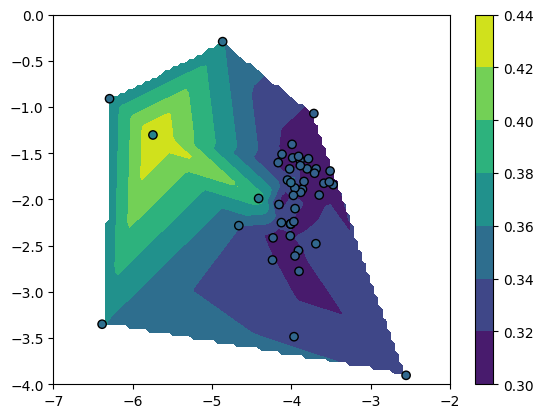

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

def interp_contour_plt(x, y, z, x_min, x_max, y_min, y_max, method='linear'):
    fig, ax = plt.subplots()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    v = ~np.isnan(z)
    x, y, z = x[v], y[v], z[v]
    zz = scipy.interpolate.griddata(
        np.stack((x, y), axis=-1), z,
        np.stack((xx, yy), axis=-1), method=method)
    cont = ax.contourf(xx, yy, zz)
    ax.scatter(x, y, color=cont.cmap(z), edgecolors='k')
    fig.colorbar(cont)
    return fig, ax

v = all_df['pruned'] == 0
fig, ax = interp_contour_plt(np.log10(all_df['learning_rate'][v]), np.log10(all_df['swa_lrs'][v]), all_df['val_loss_cl'][v], -7, -2, -4, 0)
plt.show()

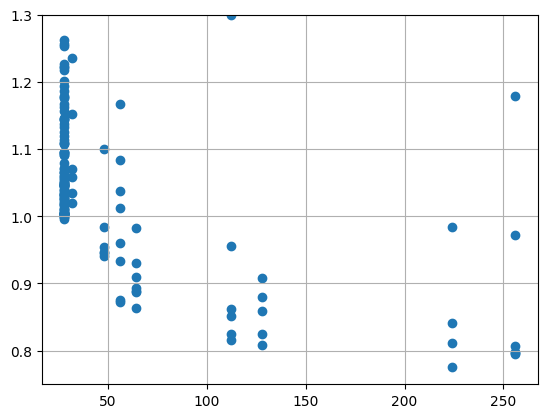

In [94]:
fig, ax = plt.subplots()
ax.scatter(all_df['chip_size'], all_df['val_loss_cl'] + all_df['val_loss_im'])
ax.set_ylim(0.75, 1.3)
ax.grid()

In [97]:
all_df['combined'] = all_df['val_loss_cl'] + 2 * all_df['val_loss_im']
all_df = all_df.sort_values(by=['combined'], ascending=True)
all_df.head(n=25)

,step,epoch,val_loss,val_loss_cl,val_loss_im,name,artifact_uri,chip_size,pruned,learning_rate,swa_lrs,loss_lambda,combined
trial_id,,,,,,,,,,,,,
87,2909,4.0,0.660231,0.391302,0.384185,run_20230406_052130Z_0_trial_86,s3://mlflow/2/f012355bdbfd48289a4e71edf822a24c...,224.0,True,1.479689e-04,0.007610,0.7,1.159672
35,2909,4.0,0.796803,0.420432,0.376370,run_20230404_000319Z_0_trial_34,s3://mlflow/2/283e6b3f874e485e8cf1c787090ef875...,256.0,True,2.258510e-04,0.057830,1.0,1.173173
68,2327,3.0,0.682425,0.412570,0.385507,run_20230405_100730Z_0_trial_67,s3://mlflow/2/83ecad36453c4154be75af6dff288f3e...,256.0,True,2.271637e-04,0.008036,0.7,1.183584
127,2909,4.0,0.675144,0.395049,0.400136,run_20230407_154913Z_0_trial_126,s3://mlflow/2/b5f5fc93594f4b71ba5865e53d90ca8a...,256.0,True,1.316917e-04,0.011619,0.7,1.195321
91,2909,4.0,0.724589,0.395898,0.410864,run_20230406_071735Z_0_trial_90,s3://mlflow/2/4acadb17a6314ac9bd84c2501860c67b...,256.0,True,1.001767e-04,0.007502,0.8,1.217627
117,2909,4.0,0.811773,0.391655,0.420118,run_20230407_064740Z_0_trial_116,s3://mlflow/2/fa1b10b121fc4c749de0f93d1154acfb...,224.0,True,4.617702e-05,0.025850,1.0,1.231891
5,148991,255.0,0.450322,0.360769,0.447765,run_20230331_040810Z_0_trial_4,s3://mlflow/2/50095a5ab9cd442f9346a22d5fd0d5ed...,128.0,False,4.113985e-07,0.000447,0.2,1.256300
46,2909,4.0,0.815669,0.371527,0.444142,run_20230404_102234Z_0_trial_45,s3://mlflow/2/c7d5998a92a54b979a7d4b5896498ee9...,112.0,True,1.591905e-04,0.013016,1.0,1.259811
101,2327,3.0,0.737096,0.385527,0.439461,run_20230406_144555Z_0_trial_100,s3://mlflow/2/f44005a3948b484a9571519d56bcb847...,128.0,True,1.709748e-04,0.018047,0.8,1.264449
